In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt

# Data Science Task
<img src="https://london.ac.uk/sites/default/files/styles/max_1300x1300/public/2018-03/data-science.jpg?itok=bTPDs5nf">

### Loading the dataset

In [2]:
data = pd.read_csv("Data/application_conversion_assessment.csv")

## 1. Feature engineering

### 1.1. Let's start with removing the features that I would not use and will not contribute to the data cleaning process:
- base_ccy
- entity
- server
- house_name
- org
- application_date
- snapshot_date

In [3]:
data = data.drop(['base_ccy', 'entity', 'server', 'house_name', 
                  'org', 'application_date', 'snapshot_date'], axis = 1)

### 1.2. Let's reformat the dependent variable to 1s and 0s

We will convert the feature values by casting them to integer

In [4]:
data['is_converted'] = data['is_converted'].astype(int)

### 1.3. Let's identify and decide what to do with the missing values

We will define a variable with all missing values and count the missing values

In [5]:
missing_values = data.isnull()

In [6]:
for column in missing_values.columns.values.tolist():
    print(column)
    print(missing_values[column].value_counts())
    print("")

country
False    20365
True      1347
Name: country, dtype: int64

referrer
False    18620
True      3092
Name: referrer, dtype: int64

application_type
False    18151
True      3561
Name: application_type, dtype: int64

kyc_status
True     15889
False     5823
Name: kyc_status, dtype: int64

screening_status
False    18150
True      3562
Name: screening_status, dtype: int64

batch_result
False    16717
True      4995
Name: batch_result, dtype: int64

received_docs
True     14500
False     7212
Name: received_docs, dtype: int64

num_inbound_emails
True     21187
False      525
Name: num_inbound_emails, dtype: int64

num_inbound_calls
True     21469
False      243
Name: num_inbound_calls, dtype: int64

num_outbound_emails
True     16263
False     5449
Name: num_outbound_emails, dtype: int64

num_outbound_calls
True     16538
False     5174
Name: num_outbound_calls, dtype: int64

is_converted
False    21712
Name: is_converted, dtype: int64



#### Number of missing values for the data points we might use out of 21712 records in total:

1. country: 1347 
2. referrer: 3092
3. kyc_status: 15889
4. screening_status: 3562
5. batch_result: 4995
6. received_docs: 14500
7. num_inbound_emails: 21187
8. num_inbound_calls: 21469
9. num_outbound_emails: 16263
10. num_outbound_calls: 16538

#### 1.3.1 Let's visualize the missing values for easier outlier spotting

<AxesSubplot:>

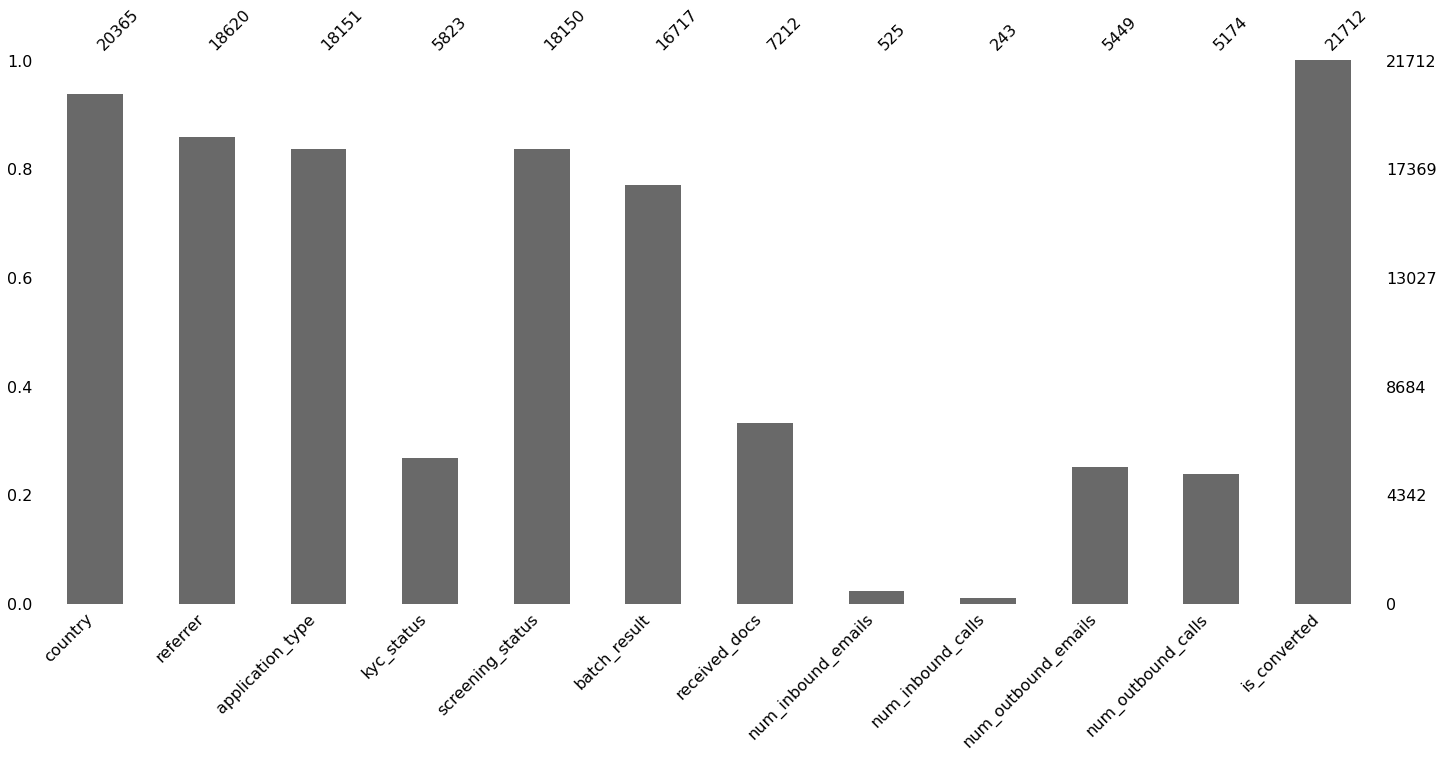

In [7]:
msno.bar(data)

#### Two main missing values categories of outliers that we should consider:

##### 1. Where I do NOT think the values can be substituted
    - 'kyc_status': 
    The 'kyc_status' is missing too many values. As I do not believe there is an empty KYC Status I think those are simply missing data records. I cannot think of a way to imputationally substitute those missing values, so will drop this feature.

##### 2. Where I do think the values can be substituted
    - 'received_docs', 'num_inbound_emails', 'num_inbound_calls', 'num_outbound_emails', 'num_outbound_calls':
    Where values are missing should mean False (no docs received, no calls/emails). Let's turn these into numerical values where 1 (or > 1 for calls, emails) is True (docs received, email/call made) and 0 is False (docs NOT received, email/call NOT made)
    - 'referrer' also added to this group after further consideration. 1 where values is present and 0 where there is no value, which likely means no referrer

1. Where I do NOT think the values can be substituted - Drop 'kyc_status'

In [8]:
data = data.drop(['kyc_status'], axis = 1)

2. Where I do think the values can be substituted

In [9]:
           #Replace True in 'received_docs' with 1
data['received_docs'] = data['received_docs'].replace(True, 1)

            #Replace non-null with 1 in 'referrer'
data['referrer'] = data['referrer'].notnull().mul(1)

            #Replace NaN with 0
data[['received_docs', 'num_inbound_emails', 'num_inbound_calls', 'num_outbound_emails', 'num_outbound_calls', 
      'referrer']] = data[['received_docs', 'num_inbound_emails', 'num_inbound_calls', 'num_outbound_emails', 
                        'num_outbound_calls', 'referrer']].fillna(0)

#### Let's see the result

<AxesSubplot:>

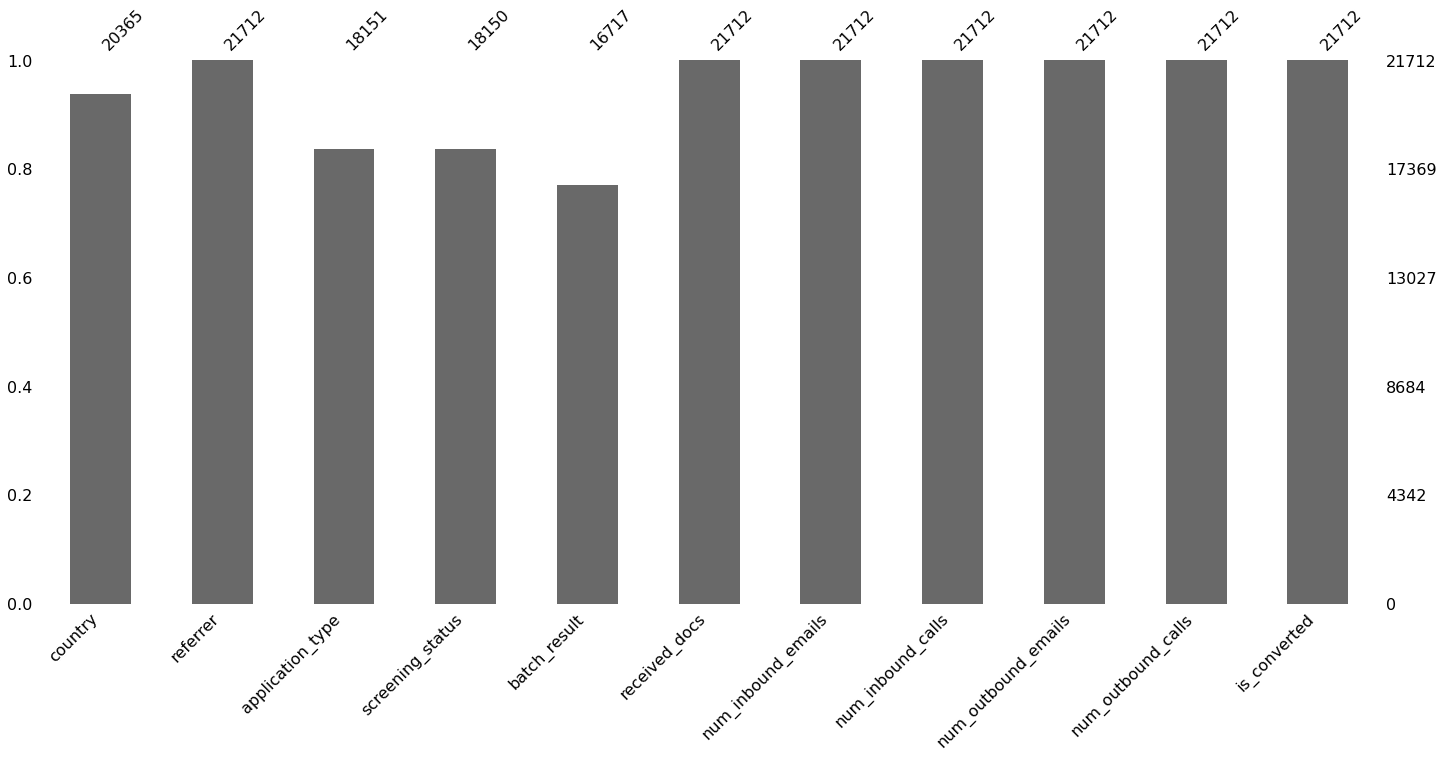

In [10]:
msno.bar(data)

#### 1.3.2. Now let's see if we can remove some of the feature records that are missing
Will use 'country' for reference as it is the feature with least missing values

In [11]:
missing_country = data[data['country'].isnull()]
missing_country['is_converted'].value_counts()

0    1341
1       6
Name: is_converted, dtype: int64

There are **6 out of 1347** records of missing 'country' value **where the client actually made a deposit**.

<AxesSubplot:>

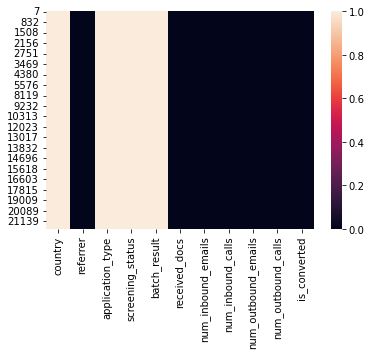

In [12]:
sns.heatmap(missing_country.isnull())

From the heatmap above we can see that where country is missing the other features ('screening_status', 'batch_result', 'application_type') are also missing values.

Although in 6 out of 1347 records the client made a deposit, these 1347 records are missing values in multiple features. Because of this we will remove them in case the data for these records is incorrectly/partially reported and could compromise the model.

#### Let's see the result

<AxesSubplot:>

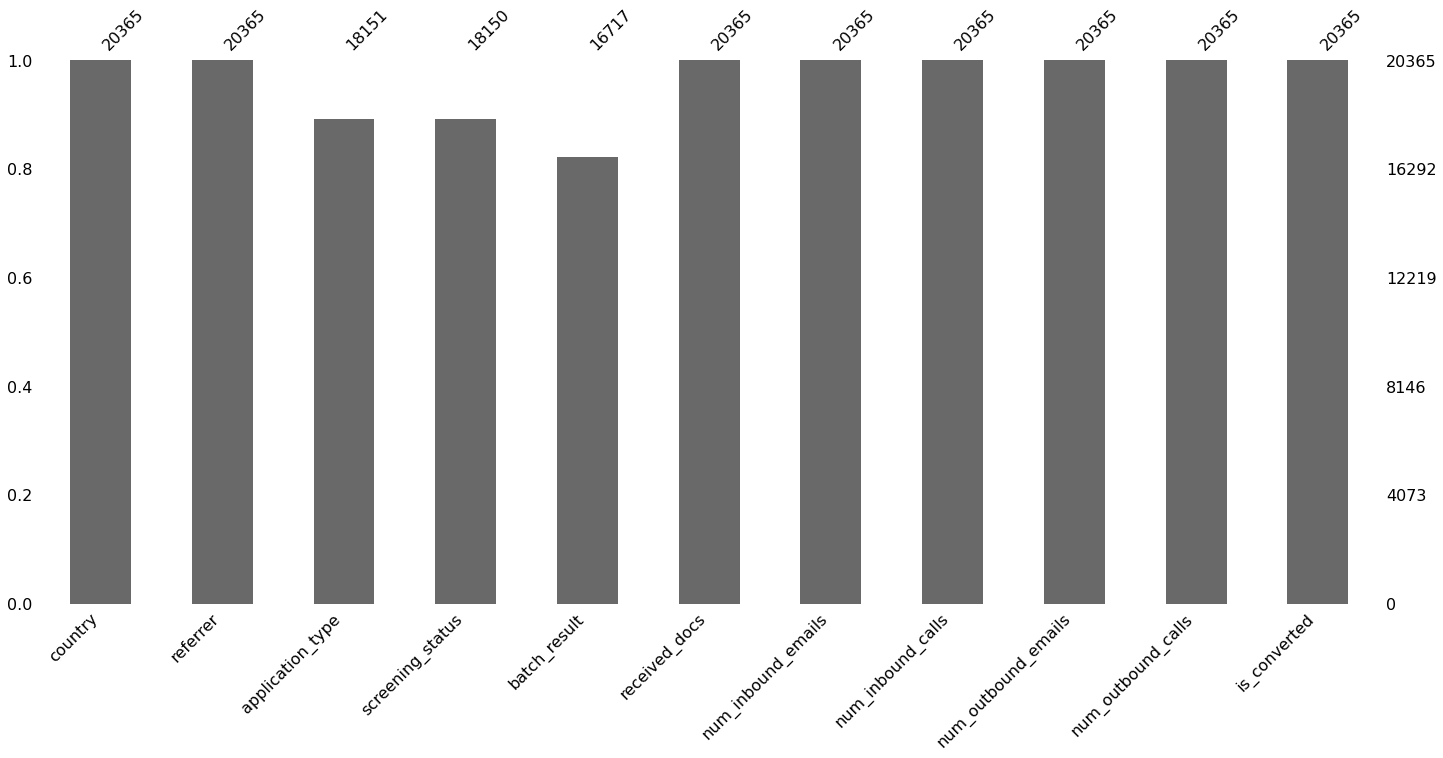

In [13]:
data = data.dropna(axis = 0, how = 'all', subset = ['country'])
data.reset_index(inplace = True)
data = data.drop('index', axis = 1)
msno.bar(data)

#### 1.3.3. Now we are left with 'screening_status', 'batch_result', 'application_status' where values are missing.

#### 1.3.3.1. 'batch_result'

Let's see the distribution

In [14]:
data['batch_result'].value_counts()

PASS     13157
match     3560
Name: batch_result, dtype: int64

Let's see the number of missing values

In [15]:
data['batch_result'].isnull().value_counts()

False    16717
True      3648
Name: batch_result, dtype: int64

Would like to fill the missing 3648 values of 'batch_result' with 0 or 1 randomly based on the proportion of 'Pass' = 78.7% and 'match' = 21.3%

The below is the best I could figure out in an hour, which is filling missing values 50/50 with 0 and 1 on random

In [16]:
random_0_1 = pd.Series(np.random.randint(2, size = len(data['batch_result'].isnull())))

In [17]:
data['batch_result'] = data['batch_result'].fillna(random_0_1)
data['batch_result'].value_counts()

PASS     13157
match     3560
0         1845
1         1803
Name: batch_result, dtype: int64

**Above**: Missing values replaced by 0 or 1 randomly

**Below**: Values replaced with 0 for PASS and 1 for match

In [18]:
data['batch_result'] = data['batch_result'].replace('PASS', 0)
data['batch_result'] = data['batch_result'].replace('match', 1)
data['batch_result'].value_counts()

0    15002
1     5363
Name: batch_result, dtype: int64

#### 1.3.3.2. 'screening_status'

In [19]:
data['screening_status'].value_counts()

Batch - Processed    9909
Ops Reviewed         2336
Completed            2284
Batch - Reviewed     2002
Pending Review       1419
Rejected              199
Pending                 1
Name: screening_status, dtype: int64

The 'Pending Review', 'Rejected', 'Pending' statuses indicate that the **application has not been completed**. This should mean that the client cannot yet technically make a deposit.

Thus, the records with these 'screening_status'es are not relevant to our analysis. Because these clients cannot be converted/ cannot make a deposit/ the **is_converted will always be False**.

In [20]:
remove_values_ss = ['Pending Review', 'Rejected', 'Pending']
data = data[data.screening_status.isin(remove_values_ss) == False]
data.reset_index(inplace = True)
data = data.drop('index', axis = 1)
print(data['screening_status'].isnull().value_counts())
print()
print(data['screening_status'].value_counts())

False    16531
True      2215
Name: screening_status, dtype: int64

Batch - Processed    9909
Ops Reviewed         2336
Completed            2284
Batch - Reviewed     2002
Name: screening_status, dtype: int64


After cleaning the data from irrelevant records we can drop the 'screening_status' from the dataset as we do not consider it to be related to is_converted

In [21]:
data = data.drop('screening_status', axis = 1)

#### 1.3.3.3. 'application_type'

In [22]:
data['application_type'].value_counts() 

Individual    16132
Joint           398
Trust             1
Corporate         1
Name: application_type, dtype: int64

Let's remove Trust and Corporate as these two accounts are unlikely to have deposited considering the average difference between application_date and snapshot_date is less than 2 days and these applications take much longer to process and consequently deposit. 

This hypothesis can be tested by comparing the dates for those records. To be noted that before removing the screening statuses that indicate incomplete application there were 46 records for Trust/Corporate accounts. After that we are left with 2.

In [23]:
remove_values_at = ['Trust', 'Corporate']
data = data[data.application_type.isin(remove_values_at) == False]
data.reset_index(inplace = True)
data = data.drop('index', axis = 1)
print(data['application_type'].isnull().value_counts())
print()
print(data['application_type'].value_counts())

False    16530
True      2214
Name: application_type, dtype: int64

Individual    16132
Joint           398
Name: application_type, dtype: int64


Next, we remove the feature altogether as it does not bring enough variability for a variable. 97% of the records are for Individual applications. Also to be noted that Joint Account option has been discontinued, meaning no new Joint applications will be received in the future.

In [24]:
data = data.drop('application_type', axis = 1)

## 2. Basic Logistic Regression Model - without country

### 2.1 Splitting the data into train and test subsets

In [25]:
y_data = data['is_converted']
x_data = data[['referrer', 'batch_result', 'received_docs', 'num_inbound_emails', 'num_inbound_calls', 
               'num_outbound_emails', 'num_outbound_calls']]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.30, random_state = 0)

### 2.2 Let's build a logistic regretion model

Initiating and fitting the model

In [26]:
l_reg = LogisticRegression()

l_reg.fit(x_train, y_train)

LogisticRegression()

Let's define a prediction

In [27]:
y_pred = l_reg.predict(x_test)

### 2.3 Let's evaluate the model

In [28]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      5114
           1       0.50      0.01      0.02       510

    accuracy                           0.91      5624
   macro avg       0.71      0.51      0.49      5624
weighted avg       0.87      0.91      0.87      5624



Although the accuracy of the model is quite high (91%), we can see that the correctly predicted 1 (is_converted == True) in low (50%)

In [29]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[5108,    6],
       [ 504,    6]], dtype=int64)

What the above confusion matrix is telling us about the predictions:
- True positive predictions: 5108
- True negative predictions: 6
- False Positive predictions: 504
- False negative predictions: 6

Let's evaluate the model using Receiver Operating Characteristic Curve

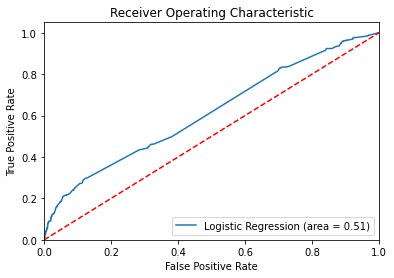

In [30]:
logit_roc_auc = metrics.roc_auc_score(y_test, l_reg.predict(x_test))
fpr, tpr, thresholds = metrics.roc_curve(y_test, l_reg.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

As it can be seen on the graph, the model is not very good at distinguishing between Positive and Negative class. This makes it a bad predictor model.

## 3. Basic Logistic Regression Model - with country

### 3.1 Let's convert 'country' into dummies

In [31]:
data_dummy_countries = pd.get_dummies(data,
                                     columns = ['country'])
display(data_dummy_countries)

,referrer,batch_result,received_docs,num_inbound_emails,num_inbound_calls,num_outbound_emails,num_outbound_calls,is_converted,country_Afghanistan,country_Albania,...,country_Uganda,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan,country_Venezuela,country_Vietnam,country_Yemen,country_Zambia
0,1,0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18739,1,1,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18740,1,1,1.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18741,1,0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18742,1,0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 3.2 Let's splitting the data into train and test subsets

In [32]:
x_data = data_dummy_countries.drop('is_converted', axis = 1)
y_data = data_dummy_countries['is_converted']

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.30, random_state = 0)

### 3.3 Let's build a logistic regretion model

Initiating and fitting the model

In [33]:
l_reg = LogisticRegression(max_iter=200)

l_reg.fit(x_train, y_train)

LogisticRegression(max_iter=200)

Let's define a prediction

In [34]:
y_pred = l_reg.predict(x_test)

### 3.4 Let's evaluate the model

In [35]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      5114
           1       0.52      0.02      0.04       510

    accuracy                           0.91      5624
   macro avg       0.72      0.51      0.50      5624
weighted avg       0.88      0.91      0.87      5624



Even with the addition of 'country', the model is giving us similar results for 'is_converted' == True precision (52%)

In [36]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[5104,   10],
       [ 499,   11]], dtype=int64)

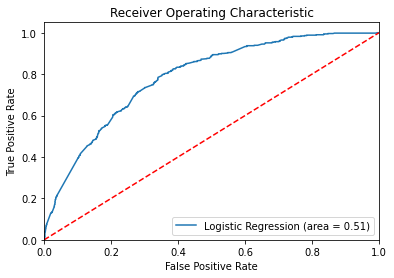

In [37]:
logit_roc_auc = metrics.roc_auc_score(y_test, l_reg.predict(x_test))
fpr, tpr, thresholds = metrics.roc_curve(y_test, l_reg.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

With country the model is slightly better, but still not a good predictor